# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform. 
I will build out a number of different methods for making recommendations that can be used for different situations. 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [43]:
# Show df_content to get an idea of the data
print(df_content.shape)
df_content.head()

(1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

I will use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Let us understand the distribution of how many articles a user interacts within the dataset.  I shall also look for a visual and descriptive statistics to assist me, with giving a look at the number of times each user interacts with an article.  

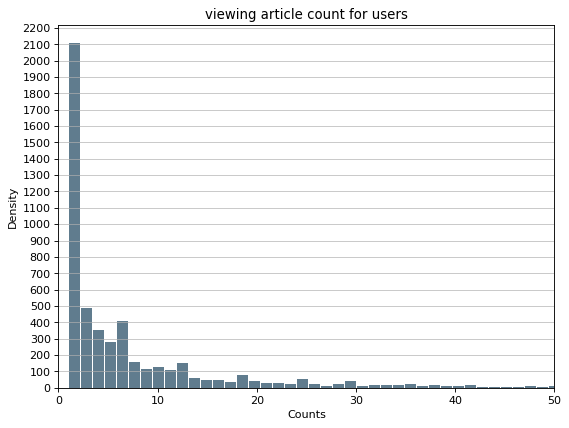

In [44]:
# counting articles per user
UsrArt_group = df.sort_values('article_id')
UsrArt_group['counter']=1
UsrArt_group = UsrArt_group.groupby(['email'])['counter'].sum()
# making email a column from index
UsrArt_group = pd.DataFrame(data = UsrArt_group)
UsrArt_group.reset_index(inplace=True)

# plotting the histograms of viweing time counts
plt.figure(num=None, figsize=(8, 6), dpi=80)
UsrArt_group.counter.plot.hist(grid=False, bins=300, rwidth=0.9,
                   color='#607c8e')
plt.yticks(np.arange(0, 2300, 100))
#plt.xticks(np.arange(0, 50, 10))
plt.xlim(xmin=0, xmax = 50)
plt.title('viewing article count for users')
plt.xlabel('Counts')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

In [45]:
# Fill in the median and maximum number of user_article interactios below

median_val = UsrArt_group['counter'].median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = max(UsrArt_group['counter'])# The maximum number of user-article interactions by any 1 user is ______.

print('the 50% individuals interact with',int(round(median_val)),'number or fewer')
print('The maximum number of user-article interactions by any 1 user is',max_views_by_user)

the 50% individuals interact with 3 number or fewer
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the dataframe.  

In [46]:
# Find and explore duplicate articles
print('The shape of articles dataframe is:',df.shape)
print('The number of duplicate articles:',sum(df.duplicated()))

The shape of articles dataframe is: (45993, 3)
The number of duplicate articles: 12311


In [47]:
# Remove any rows that have the same article_id - only keep the first
print('The shape of the dataframe after removing duplicates:',df.drop_duplicates(subset='article_id', keep="first").shape)

The shape of the dataframe after removing duplicates: (714, 3)


`3.` Our next motive is to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [48]:
# Unique users in the dataset
print('The number of unique users is:',len(df['email'].dropna().unique()))

# The number of articles of IBM platform
print('Unique articles total:',len(df_content.article_id.unique()))

The number of unique users is: 5148
Unique articles total: 1051


In [49]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` I will have to now look into the article that is most viewed. It is fairly simple as we shall view it with **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function I wrote below).

In [50]:
# The most viewed article
print('The most viewed article is:',df['article_id'].value_counts().idxmax())

# The number of times it was viewed
print('The max views on an article',df['article_id'].value_counts().max())

The most viewed article is: 1429.0
The max views on an article 937


In [51]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(1429.0)
# The most viewed article in the dataset was viewed how many times?
max_views = 937

In [52]:
# This function is to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [53]:
# Running test cases in dictionary against our values stored in respective variables to ckeck if we are on right path

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Testing dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below, returns the **n** top articles ordered with most interactions as the top. Then, I shall test my function using the test cases given to me below.

In [54]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index[:n]
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index[:n]
    return top_articles # Return the top article ids

In [55]:
# Testing my function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of my three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Time to write a function that allowed me to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user**, only appears in each **row** once.


* Each **article**, only show up in one **column**.  


* **If a user has interacted with an article, then a 1 is place where the user-row meets for that article-column**. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article are 1.  


* **If a user has not interacted with an item, then a 0 is placed where the user-row meets for that article-column**. 

Again, I am using the given test cases to make sure the basic structure of my matrix matches what is expected by the solution.

In [56]:
# creating the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # The function
    
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype('int')
    
    return user_item # return the user_item matrix     

user_item = create_user_item_matrix(df)

In [57]:
## Running against the Tests:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below, takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Again, using the test cases to test my function.

In [58]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    # computing the similarity of each user to the provided user
    
    # sorting by similarity
    
    # creating a list of just the ids
   
    # remove the own user's id
    most_similar_users =user_item.dot(user_item.loc[user_id,:]).sort_values(ascending=False).index.values
    most_similar_users = most_similar_users[user_id != most_similar_users]
    return most_similar_users # return a list of the users in order from most to least similar

In [59]:
# Doing a spot check of my function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that I've a function that provides me with the most similar users to each user, I shall use these users to find articles I can recommend to each user.

In [60]:
# Getting article names by passing a list
df[df['article_id'].isin([0,1444,2])]['title'].unique()

array(['detect malfunctioning iot sensors with streaming analytics',
       'worldwide fuel oil consumption by household (in 1000 metric tons)',
       'this week in data science (april 18, 2017)'], dtype=object)

In [61]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = df[df['user_id'] == user_id]['article_id'].unique().tolist()
    article_ids = [str(i) for i in article_ids]  # Converting id(s) to strings format
    article_names = df[df['user_id'] == user_id]['title'].unique().tolist()
    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    seen_artID, seen_artNAMES = get_user_articles(user_id)
    
    recs = []
    for user_id in similar_users:
        article_ids,article_names = get_user_articles(user_id)
        recs = np.setdiff1d(article_ids,seen_artID)
        recs = recs[:m]
        
        if len(recs) >= m:
            break;
        
    return recs # returning recommendations given user_id    

In [62]:
# Checking Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['analyze energy consumption in buildings',
       'analyze accident reports on amazon emr spark',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'data tidying in data science experience',
       'airbnb data for analytics: vancouver listings',
       'recommender systems: approaches & algorithms',
       'airbnb data for analytics: mallorca reviews',
       'analyze facebook data using ibm watson and watson studio',
       'a tensorflow regression model to predict house values'], dtype=object)

In [63]:
# Testing my functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` I will now improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when I obtain users who are all the same closeness to a given user - I shall choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user, where the number of recommended articles starts below m and ends exceeding m, I shall choose articles with the articles, with the most total interactions before choosing those with fewer total interactions. This ranking should be, what would be obtained from the **top_articles** function I wrote earlier.

In [64]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe 0
    '''
    neighbors_df = df
    neighbors_df = neighbors_df.groupby(['user_id']).count().drop('title', axis=1)  # Counting article read by each user

    neighbors_df['dot_prod'] = user_item.dot(user_item.loc[user_id,:])              # Getting correlated users for given user_id
    
    # Tie breaker of correlated users by sorting them in descending no. of articles interacted by each user
    neighbors_df = neighbors_df.sort_values(['dot_prod',                
                                             'article_id'], ascending=False).reset_index().groupby(['dot_prod','article_id'])
                                                                                     
    neighbors_df = neighbors_df.apply(lambda x: x).set_index('user_id')             # Converting groupby df to df 
    neighbors_df = neighbors_df[neighbors_df.index.values != 
                                user_id].index.values         # Removing row of corr. of user to itself and returning user_id(s) 
    
    return neighbors_df                                       # Return the dataframe specified in the doc_string
    

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''          
    recs, rec_names = [],[]
    try:
        user_ids = get_top_sorted_users(user_id)
        for u in user_ids:
            art_id, art_name = get_user_articles(u)
            if len(recs) <= 10:
                recs.append(art_id[0])
                rec_names.append(art_name[0])
            else:
                break;
    except KeyError:
        rec_names = get_top_articles(m)
        recs = get_top_article_ids(m)
    recs, rec_names = recs.tolist(), rec_names.tolist()
    return recs, rec_names

In [65]:
# Quick spot check for testing my functions
rec_ids, rec_names = user_user_recs_part2(0, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


`5.` Using my functions from above to correctly fill in the solutions to the dictionary below.  Then, testing my dictionary against the solution.

In [66]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [67]:
## Dictionary Test again
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` I will have to come up with different approach if I was given a new user. None of the above approaches would come to rescue if a new user is given to me.

`7.` Using my existing functions, I shall provide the top 10 recommended articles that I would provide for the new user. I can test my function against my thoughts to make sure I am on the right page with how I might make a recommendation.

In [68]:
# What would my recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
new_user = '0.0'

# Provide a list of the top 10 article ids I would give to user with id 0 
new_user_recs = [str(i) for i in (user_user_recs_part2(new_user)[0])]

In [69]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I will build matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` I have already created a **user_item** matrix above in **question 1** of **Part III** above. 

In [72]:
# Loading the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [73]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I will use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [74]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

`3.` Now for the tricky part, how do I choose the number of latent features to use?  Below, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  The accuracy improves as we increase the number of latent features.

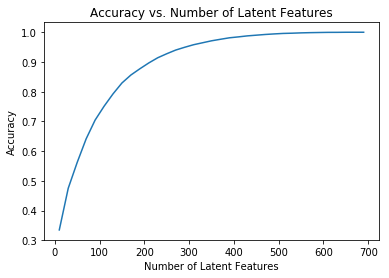

In [75]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, I can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give me an indication, if I am to make good recommendations. Instead, I would split our dataset into a training and test set of data, as shown in the cell below.  

Reusing my code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. I will use the split to understand; 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [76]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype('int')
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype('int')
    
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [77]:
# Number of articles we cant make prediction for:
cnt = 0
for u in user_item_test.columns.values:
    if u not in user_item_train.columns.values:
        cnt += 1
print('Number of articles we cant make predictions for', cnt,'while we can for', user_item_test.shape[1]-cnt)

# Number of users we cant make predictions for:
cnt = 0
for u in user_item_test.index.values:
    if u not in user_item_train.index.values:
        cnt += 1
print('Number of users we cant make predictions for', cnt,'while we can for', user_item_test.shape[0]-cnt)

Number of articles we cant make predictions for 0 while we can for 574
Number of users we cant make predictions for 662 while we can for 20


In [78]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` I shall use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then, find the subset of rows in the **user_item_test** dataset that I can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require me to combine what was done in questions `2` - `4`.

In [79]:
# fitting SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fitting svd similar to above

In [81]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

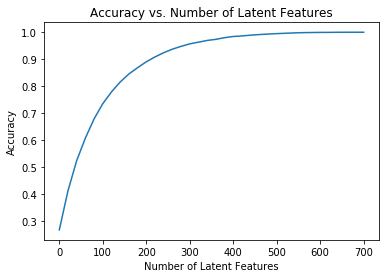

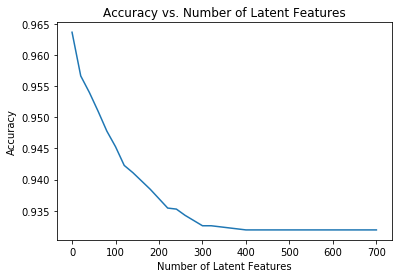

In [82]:
num_latent_feats = np.arange(0,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test.loc[user_item_test.index.isin(user_item_train.index)], user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(df_train.shape[0]), label='Train');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(df_test.shape[0]), label='Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

**Inference**

Since there were only 20 individuals who co-existed between the training and testing data-sets, there isn't exactly a lot data that can be used to test how well predictions were via collaborative filtering with SVD are matching up with actual values.Though the above plot makes it look like we are doing great in terms of accuracy, this is largely due to the class imbalance of 1's and 0's of lacking variability in our imbalanced dataset.

Due to less data and imbalanced class we are not sure if the accuracy is doing bad or good. But we can do certainly tell that if the accuracy is increasing on test set with number of users and going down for test set, then variety is lacking in our dataset. It appears that the accuracy is plummiting as the number of Latent Features increases. This could be due to not much variety being in the datasets that could really generalize the data well when performing on the testing set. What we could do, is to shuffle the data more so that we could train on a more diversified set of data. We might also use K-Fold or LOCV - Leave one Out Cross Validation for esuring variability in our dataset and then select the latent features accordingly.

